In [33]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from skimage import io, color
from sklearn import metrics

import time
import os
import pickle

import matplotlib.pyplot as plt
#import scikitplot as skplt

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Model

In [3]:
googlenet = models.googlenet(pretrained=True)
#resnet18 = models.resnet18(num_classes=2)

In [4]:
root_dir = '/home/yz6121/dl/data/data/'
model = googlenet.to(device)
model.load_state_dict(torch.load(root_dir+'best_gn21_model_.pth'))
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Data loading&Train

In [0]:
#resnet
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364, 364]),
        transforms.RandomResizedCrop(320),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [5]:
class ChestXray(Dataset):

    def __init__(self, csv_file, image_root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.image_root_dir = image_root_dir
        self.image_path = self.data_frame['image_index']
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        image_filename = self.image_root_dir + self.image_path[index]
        image = io.imread(image_filename, as_gray=True)
        
        sample = {}
        
        # need to transpose: input size for ToPILImage() is H*W*C not C*H*W
        image = np.repeat(image[None,...], 3, axis=0).transpose(1, 2, 0)
        
        if self.transform:
            image = self.transform(np.uint8(image))

        sample['image'] = image
        
        label_col_names = ['normal', 'pneumonia']
        
        sample['label'] = torch.LongTensor([self.data_frame['label'][index]])
        
        return sample

In [0]:
def train(model, optimizer, criterion, loader, device):
    
    model.train()

    running_loss = 0.0
    epoch_loss = 0.0
    total_samples = 0
    correct = 0 

    for batch_idx, samples in enumerate(loader):
        
        image = samples['image'].to(device)
        label = samples['label'].squeeze()
        label = torch.tensor(label, dtype=torch.long, device=device)
        
        preds = model(image)        
        
        loss = train_criterion(preds, label)
        running_loss += loss.item()
        epoch_loss += loss.item()
        
        total_samples += image.shape[0]
        correct += torch.sum(torch.max(preds, dim=1)[1] == label).item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss = 0.0

    training_accuracy = correct / total_samples

    return epoch_loss / len(loader), training_accuracy

In [0]:
#new
def validation(model, optimizer, criterion, loader, device):

    model.eval( )

    running_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    preds_list = []
    truelabels_list = []
    probas_list = []

    with torch.no_grad():
        for batch_idx, samples in enumerate(loader):

            image = samples['image'].to(device)
            label = samples['label'].squeeze()
            label = torch.tensor(label, dtype=torch.long, device=device)

            output = model(image)
            output_softmax = mysoftmax(output)

            _, preds = torch.max(output, dim = 1)

            loss = criterion(output, label)
            running_loss += loss.item()

            total_samples += image.shape[0]
            correct += torch.sum(preds == label).item()

            preds_list.append(preds.cpu().numpy())
            truelabels_list.append(label.cpu().numpy())
            probas_list.append(output_softmax.cpu().numpy())

        valid_accuracy = correct / total_samples

        probas_list = np.vstack(probas_list)
        truelabels_list = np.concatenate(truelabels_list)
        preds_list = np.concatenate(preds_list)

        auc_score = metrics.roc_auc_score(truelabels_list, preds_list)

        return running_loss / len(loader), valid_accuracy, preds_list, truelabels_list, probas_list, auc_score

In [0]:
train_df_path = '/home/yz6121/dl/data/data/train.csv'
val_df_path = '/home/yz6121/dl/data/data/val.csv'
root_dir = '/home/yz6121/dl/data/data/'

bs = 10
#epochs = 10

train_loader = DataLoader(ChestXray(train_df_path, root_dir, transform=train_transform), batch_size=bs, shuffle=True)
valid_loader = DataLoader(ChestXray(val_df_path, root_dir, transform=validation_transform), batch_size=bs, shuffle=False)    
                                                         
#model = googlenet

#model.to(device)


optimizer = optim.Adam(model.parameters(),lr = 0.001)

criterions = []

#history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

#best_val_loss = np.inf



In [ ]:
with open("history_gn1.pkl", 'rb') as fo:
    history_gn1 = pickle.load(fo, encoding='bytes')

In [0]:
from numpy import *
def train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device):
    history = {"train_loss":[], "train_acc":[],
           "valid_loss":[], "valid_acc":[], "valid_preds_list":[],
           "valid_truelabels_list":[], "valid_probas_list":[], "valid_auc_score":[]}
    #or:
    #history = history_gn1

    best_acc = 0
    #or:
    #best_acc = max(history['valid_acc'])
    since = time.time()
    for epoch in range(epochs): 
        print('Epoch: {}/{}'.format(epoch, epochs-1))
        print('-'*10)
        #train
        train_loss, train_acc = train(model, optimizer, train_criterion, train_loader, device)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format('train', train_loss, train_acc))

        #validation
        valid_loss, valid_acc, valid_preds_list, valid_truelabels_list, valid_probas_list, valid_auc_score = validation(model, optimizer, valid_criterion, valid_loader, device)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)
        history["valid_preds_list"].append(valid_preds_list)
        history["valid_truelabels_list"].append(valid_truelabels_list)
        history["valid_probas_list"].append(valid_probas_list)
        history["valid_auc_score"].append(valid_auc_score)
      
        
        print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format('validation', valid_loss, valid_acc))

        #save model
        if valid_acc>best_acc:
            best_acc = valid_acc
            best_model_file = root_dir + "best_gn_model_.pth"
            torch.save(model.state_dict(), best_model_file)
            best_model_wts = model.state_dict()

        if epoch%5 == 0:
            with open("history_gn.pkl", "wb") as fout:
                pickle.dump(history, fout)
        #or:
        #if abs(mean(history['train_loss'][:-10])-history['train_loss'][:-1])<0.005:
            #break



    model.load_state_dict(best_model_wts)

    #save loss/acc
    if epoch == epochs - 1:
        with open("history_gn.pkl", "wb") as fout:
            pickle.dump(history, fout)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, history

    

In [0]:
#googlenet:best_gn1_model_ continue
epochs = 50
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
model_gn2, history_gn2 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1265 Acc: 0.9533


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0804 Acc: 0.9694
Epoch: 1/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1351 Acc: 0.9498


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1052 Acc: 0.9570
Epoch: 2/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1299 Acc: 0.9523


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0895 Acc: 0.9653
Epoch: 3/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1349 Acc: 0.9528


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0987 Acc: 0.9587
Epoch: 4/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1195 Acc: 0.9572


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0598 Acc: 0.9744
Epoch: 5/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1198 Acc: 0.9545


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1113 Acc: 0.9669
Epoch: 6/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1244 Acc: 0.9540


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0683 Acc: 0.9760
Epoch: 7/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1180 Acc: 0.9585


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0768 Acc: 0.9694
Epoch: 8/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1328 Acc: 0.9478


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1287 Acc: 0.9504
Epoch: 9/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1072 Acc: 0.9624


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0717 Acc: 0.9736
Epoch: 10/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1260 Acc: 0.9513


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0778 Acc: 0.9727
Epoch: 11/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1219 Acc: 0.9540


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0743 Acc: 0.9702
Epoch: 12/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1224 Acc: 0.9520


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0576 Acc: 0.9736
Epoch: 13/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1199 Acc: 0.9525


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0649 Acc: 0.9736
Epoch: 14/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1121 Acc: 0.9582


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0663 Acc: 0.9727
Epoch: 15/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1091 Acc: 0.9632


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0647 Acc: 0.9785
Epoch: 16/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1109 Acc: 0.9599


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0622 Acc: 0.9760
Epoch: 17/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1142 Acc: 0.9590


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1570 Acc: 0.9455
Epoch: 18/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1178 Acc: 0.9609


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0874 Acc: 0.9669
Epoch: 19/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1005 Acc: 0.9629


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0827 Acc: 0.9702
Epoch: 20/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1061 Acc: 0.9644


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0845 Acc: 0.9661
Epoch: 21/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1092 Acc: 0.9609


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1423 Acc: 0.9413
Epoch: 22/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1072 Acc: 0.9557


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0572 Acc: 0.9785
Epoch: 23/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1051 Acc: 0.9636


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0777 Acc: 0.9727
Epoch: 24/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1125 Acc: 0.9572


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0712 Acc: 0.9744
Epoch: 25/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1002 Acc: 0.9622


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1713 Acc: 0.9364
Epoch: 26/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0987 Acc: 0.9622


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0659 Acc: 0.9744
Epoch: 27/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1117 Acc: 0.9594


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0832 Acc: 0.9694
Epoch: 28/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1164 Acc: 0.9585


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0570 Acc: 0.9777
Epoch: 29/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1092 Acc: 0.9634


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0801 Acc: 0.9702
Epoch: 30/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1024 Acc: 0.9632


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0552 Acc: 0.9769
Epoch: 31/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1003 Acc: 0.9622


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0765 Acc: 0.9702
Epoch: 32/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1014 Acc: 0.9597


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0645 Acc: 0.9785
Epoch: 33/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0898 Acc: 0.9664


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0795 Acc: 0.9777
Epoch: 34/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1035 Acc: 0.9599


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0665 Acc: 0.9769
Epoch: 35/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0879 Acc: 0.9664


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0609 Acc: 0.9793
Epoch: 36/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1032 Acc: 0.9609


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0646 Acc: 0.9777
Epoch: 37/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1004 Acc: 0.9641


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0601 Acc: 0.9760
Epoch: 38/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1011 Acc: 0.9627


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0796 Acc: 0.9686
Epoch: 39/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0960 Acc: 0.9651


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0824 Acc: 0.9769
Epoch: 40/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0892 Acc: 0.9646


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0540 Acc: 0.9769
Epoch: 41/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0955 Acc: 0.9639


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0714 Acc: 0.9711
Epoch: 42/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1052 Acc: 0.9587


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0711 Acc: 0.9736
Epoch: 43/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0863 Acc: 0.9674


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0797 Acc: 0.9736
Epoch: 44/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0830 Acc: 0.9693


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0794 Acc: 0.9694
Epoch: 45/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0927 Acc: 0.9622


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0653 Acc: 0.9777
Epoch: 46/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0884 Acc: 0.9688


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0739 Acc: 0.9702
Epoch: 47/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0827 Acc: 0.9706


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0818 Acc: 0.9727
Epoch: 48/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0810 Acc: 0.9716


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0614 Acc: 0.9785
Epoch: 49/49
----------


<ipython-input-10-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.0886 Acc: 0.9686


<ipython-input-11-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0598 Acc: 0.9769
Training complete in 213m 39s


In [0]:
#googlenet:best_gn1_model_ continue
epochs = 10
#train_criterion = nn.CrossEntropyLoss()
#valid_criterion = nn.CrossEntropyLoss()
model_gn2, history_gn2 = train_gn(epochs, model_gn1, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1665 Acc: 0.9355


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1575 Acc: 0.9339
Epoch: 1/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1764 Acc: 0.9308


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1736 Acc: 0.9281
Epoch: 2/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1706 Acc: 0.9330


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0867 Acc: 0.9661
Epoch: 3/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1627 Acc: 0.9382


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0892 Acc: 0.9694
Epoch: 4/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1588 Acc: 0.9404


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.2663 Acc: 0.8868
Epoch: 5/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1691 Acc: 0.9372


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1356 Acc: 0.9479
Epoch: 6/9
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


In [0]:
#googlenet:best_gn_model
epochs = 20
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
model_gn1, historygn1 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.3136 Acc: 0.8680


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1763 Acc: 0.9372
Epoch: 1/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2805 Acc: 0.8771


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1706 Acc: 0.9306
Epoch: 2/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2689 Acc: 0.8947


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.2721 Acc: 0.8727
Epoch: 3/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2812 Acc: 0.8833


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1399 Acc: 0.9380
Epoch: 4/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2537 Acc: 0.8909


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.3812 Acc: 0.8198
Epoch: 5/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2488 Acc: 0.8999


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1921 Acc: 0.9339
Epoch: 6/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2397 Acc: 0.9048


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1500 Acc: 0.9488
Epoch: 7/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2276 Acc: 0.9065


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1194 Acc: 0.9595
Epoch: 8/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2338 Acc: 0.9050


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1230 Acc: 0.9595
Epoch: 9/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2252 Acc: 0.9149


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1387 Acc: 0.9471
Epoch: 10/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2258 Acc: 0.9152


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1040 Acc: 0.9636
Epoch: 11/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2176 Acc: 0.9174


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1718 Acc: 0.9355
Epoch: 12/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2112 Acc: 0.9196


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1169 Acc: 0.9570
Epoch: 13/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1856 Acc: 0.9330


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0937 Acc: 0.9620
Epoch: 14/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.2003 Acc: 0.9251


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1109 Acc: 0.9612
Epoch: 15/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1967 Acc: 0.9211


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1344 Acc: 0.9471
Epoch: 16/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1899 Acc: 0.9308


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1176 Acc: 0.9603
Epoch: 17/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1856 Acc: 0.9308


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1203 Acc: 0.9570
Epoch: 18/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1851 Acc: 0.9313


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.0958 Acc: 0.9612
Epoch: 19/19
----------


<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.1807 Acc: 0.9310


<ipython-input-7-2191c8e4aaf5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.1095 Acc: 0.9636
Training complete in 81m 1s


In [0]:
#googlenet:best_googlenet_model
epochs = 10
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
model_gn, historygn = train_vgg16(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

<ipython-input-6-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.4434 Acc: 0.8343
Phase:validation, epoch loss: 0.2065 Acc: 0.9165
Phase:train, epoch loss: 0.3063 Acc: 0.8724
Phase:validation, epoch loss: 0.4886 Acc: 0.7669
Phase:train, epoch loss: 0.2816 Acc: 0.8848
Phase:validation, epoch loss: 0.1622 Acc: 0.9380
Phase:train, epoch loss: 0.2768 Acc: 0.8875
Phase:validation, epoch loss: 0.2069 Acc: 0.9116
Phase:train, epoch loss: 0.2689 Acc: 0.8870
Phase:validation, epoch loss: 0.1352 Acc: 0.9512
Phase:train, epoch loss: 0.2377 Acc: 0.9068
Phase:validation, epoch loss: 0.1703 Acc: 0.9281
Phase:train, epoch loss: 0.2493 Acc: 0.9001
Phase:validation, epoch loss: 0.1241 Acc: 0.9446
Phase:train, epoch loss: 0.2380 Acc: 0.9105
Phase:validation, epoch loss: 0.0970 Acc: 0.9603
Phase:train, epoch loss: 0.2269 Acc: 0.9075
Phase:validation, epoch loss: 0.1043 Acc: 0.9661
Phase:train, epoch loss: 0.2164 Acc: 0.9100
Phase:validation, epoch loss: 0.5540 Acc: 0.7926


In [34]:
with open("history_gn21.pkl", 'rb') as fo:
    history_gn1 = pickle.load(fo, encoding='bytes')

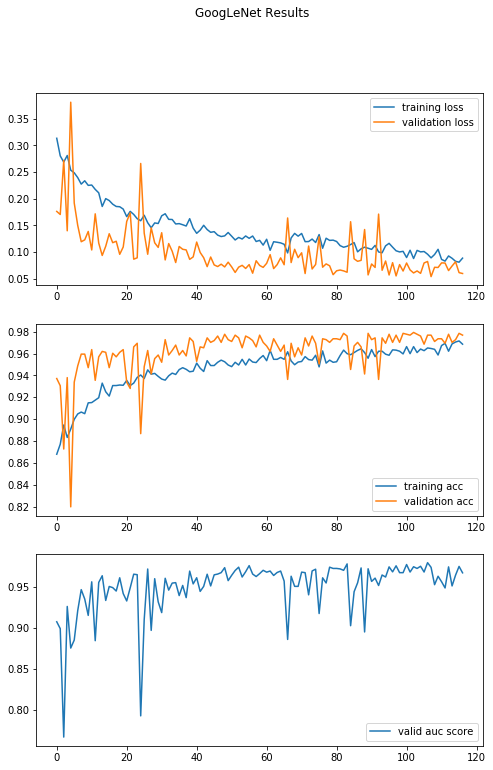

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('GoogLeNet Results')

ax1.plot(history_gn1['train_loss'], label='training loss')
ax1.plot(history_gn1['valid_loss'], label='validation loss')
ax1.legend()

ax2.plot(history_gn1['train_acc'], label='training acc')
ax2.plot(history_gn1['valid_acc'], label='validation acc')
ax2.legend()

ax3.plot(history_gn1['valid_auc_score'], label='valid auc score')
ax3.legend()

plt.savefig('GoogLeNet_train.jpeg')

# Test

In [27]:
test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
root_dir = '/home/yz6121/dl/data/data/'

test_df_path = '/home/yz6121/dl/data/data/test.csv'

bs=10

test_loader = DataLoader(ChestXray(test_df_path, root_dir, transform=test_transform), batch_size=bs, shuffle=False)    

test_weights = test_loader.dataset.data_frame.shape[0] / np.array(test_loader.dataset.data_frame['class'].value_counts())[::-1]
test_weights = torch.FloatTensor(test_weights).to(device)
#test_criterion = nn.CrossEntropyLoss(weight=test_weights)


test_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [28]:
def test(model, optimizer, criterion, loader, device):

    model.eval()

    running_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    preds_list = []
    truelabels_list = []
    probas_list = []
    with torch.no_grad():
        for batch_idx, samples in enumerate(loader):

            image = samples['image'].to(device)
            label = samples['label'].squeeze()
            label = torch.tensor(label, dtype=torch.long, device=device)

            output = model(image)
            output_softmax = mysoftmax(output)

            _, preds = torch.max(output, dim = 1)

            loss = test_criterion(output, label)
            running_loss += loss.item()

            total_samples += image.shape[0]
            correct += torch.sum(preds == label).item()


            preds_list.append(preds.cpu().numpy())
            truelabels_list.append(label.cpu().numpy())
            probas_list.append(output_softmax.cpu().numpy())

        test_accuracy = correct / total_samples

        return running_loss / len(loader), test_accuracy, preds_list, truelabels_list, probas_list


In [29]:
#new
history_gn_test = {"test_loss":[], "test_acc":[], "preds_list":[], "truelabels_list":[], "proabs_list":[]}

test_loss, test_acc, preds_list, truelabels_list, proabs_list= test(model, optimizer, test_criterion, test_loader, device)
history_gn_test["test_loss"].append(test_loss)
history_gn_test["test_acc"].append(test_acc)
history_gn_test["preds_list"].append(preds_list)
history_gn_test["truelabels_list"].append(truelabels_list)
history_gn_test["proabs_list"].append(proabs_list)

print('{}: test loss: {:.4f} Acc: {:.4f}'.format('test', test_loss, test_acc))
print()

<ipython-input-28-ff498d46d2aa>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


test: test loss: 0.0787 Acc: 0.9817



In [8]:
#From DSGA-1001 lab
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
%matplotlib inline
def plotUnivariateROC(preds, truth, label_string, title_string):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    #we are doing this as a special case because we are sending unfitted predictions #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
        #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title_string)
    plt.legend(loc="lower right")
    plt.savefig(label_string+".jpeg")
    plt.show()
    
    return roc_auc

In [9]:
#preds&truths
def pred_truth(model, dataloader):
    preds = torch.zeros(len(dataloader))
    truths = torch.ones(len(dataloader))
    i = 0
    for data in dataloader:
        image = data['image'].to(device,dtype=torch.float)
        label = data['label'].to(device,dtype=torch.long)
        output = model(image)
        _,pred = torch.max(output, dim = 1)
        preds[i]= pred
        truths[i] = label
        i += 1
        
    return preds, truths

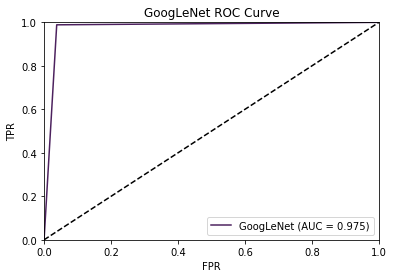

0.9754887346139103

In [11]:
#print('GoogleNet ROC Curve')
preds, truths = pred_truth(model, test_loader)
plotUnivariateROC(preds, truths, 'GoogLeNet', 'GoogLeNet ROC Curve')


In [0]:

with open("history_gn2_test.pkl", "wb") as fout:
    pickle.dump(history_gn_test, fout)

In [31]:
proabs_stacked = np.vstack(proabs_list)
true_labels = np.concatenate(truelabels_list)
pred_labels = np.concatenate(preds_list)

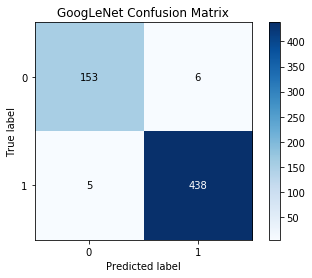

In [32]:
#new 115 epochs, save as history_gn2_test.pkl
import scikitplot as skplt
#skplt.metrics.plot_roc(true_labels, proabs_stacked)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, title = 'GoogLeNet Confusion Matrix')